In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
# import pyautogui
import threading
import math

In [10]:

class challenge_sign_detection():
    def __init__(self, *args, **kwargs):
        # super(buttonDetection, self).__init__(*args, *kwargs)
        self.img_list = []
        self.methods = ['cv.TM_CCOEFF', 
                        'cv.TM_CCOEFF_NORMED', 
                        'cv.TM_CCORR',
                        'cv.TM_CCORR_NORMED', 
                        'cv.TM_SQDIFF', 
                        'cv.TM_SQDIFF_NORMED']
        img_t = cv.imread("../pics/03-T.jpg")
        img_t = cv.cvtColor(img_t, cv.COLOR_BGR2RGB)
        img_t = cv.resize(img_t, [128, 128])
        self.template = img_t

    def setImage(self, orig_img):
        self.img_list.append(orig_img)

    def highlight(self, R, T, I, use_max=True):
        """
        Finds the location of maximum (or minimum) matching response, and 
        draws a rectangle on the image around this location.  The
        size of the rectangle is determined by template T.
        
        Returns an image with the drawn rectangle.  Also returns the loc and
        the value (maximum or minimum as the case may be).  The original image
        remains unchanged.
        """
        
        W, H = I.shape[0], I.shape[1]
        w, h = T.shape[0], T.shape[1]
        wr, hg = R.shape[0], R.shape[1]
            
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(R)
        loc = max_loc if use_max else min_loc
        val = max_val if use_max else min_val
        
        loc1 = loc + np.array([h//2, w//2])               # Size of R is different from I 
        tl = loc1 - np.array([h//2, w//2])
        br = loc1 + np.array([h//2, w//2])
        I_ = np.copy(I)
        c = (1.0, 0, 0) if I_.dtype == 'float32' else (255, 0, 0)
        cv.rectangle(I_, tuple(tl), tuple(br), c, 4)
        return I_, loc, val
        

    def make_square(self, I):
    # This function is used to construct a rectangular images to be used in generate gaussian pyramid
    # The return value are the square shaped image and the max level can be used to generate gaussian pyramid
        h = I.shape[0]
        w = I.shape[1]
        
        n_levels = int(np.ceil(np.log(np.max([h,w]))/np.log(2)))
        new_h = np.power(2, n_levels)
        new_w = new_h
        
        if len(I.shape) == 3:
            tmp = np.zeros([new_h, new_w, I.shape[2]], dtype=I.dtype)
            tmp[:h,:w,:] = I
        else:
            tmp = np.zeros([new_h, new_w], dtype=I.dtype)
            tmp[:h,:w] = I

        return tmp, n_levels


    def gen_gaussian_pyramid(self, I, levels):
        '''
        This function is used to generate gaussian pyramid
        The return value is a list contains different levels gaussian pyramid
        '''
        G = I.copy()
        gpI = [G]
        for i in range(levels):
            G = cv.pyrDown(G)
            gpI.append(G)
        return gpI



    def gen_down_sample(self, I, levels=6):
        '''
        Generate down sample images for input images
        '''
        G = I.copy()
        pI = [G]
        for i in range(levels):
            G = G[::2,::2,:]
            pI.append(G)
        return pI

    def get_relative_size(self, img_shape):
        # img_shape = orig_img.shape
        temp_box_width = img_shape[1] / 672.0
        width = math.floor(temp_box_width * 64)
        return width

    def find_highest_match_box(self, bbox_list, img_shape):
        '''
        This function receive a match box list, example [[0,0], [0,1]]
        Then using data clusting(kind of) DBSCAN to find the most possible matching place

        In this function, 
         - First, append all x axis into x_dict list and all y axis into y_dict,
            two dictionary record the frequence of each element.
         - Second, for each element in the dictionary, we set a range, for example, if the element is 123,
            then check all number in range 123 - 3 to 123 + 3, if the number in the dictionary keys, then
            add frequence, if the sum > 10, append it into a list, elements in list are all possible candidate.
         - Third, calculate the average in the candidate list, and round up, then the number should be the 
            most possible place where the button at.
        '''
        x_axis = []
        y_axis = []
        for item in bbox_list:
            x_axis.append(item[0])
            y_axis.append(item[1])

        x_dict = {}
        for item in x_axis:
            if not item in x_dict:
                x_dict[item] = 1
            else:
                x_dict[item] = x_dict[item] + 1

        # print("x_dict:", x_dict)
        
        y_dict = {}
        for item in y_axis:
            if not item in y_dict:
                y_dict[item] = 1
            else:
                y_dict[item] = y_dict[item] + 1

        # print("y_dict:", y_dict)
   
        x_list = []
        for key in x_dict.keys():
            for i in range(key - 3, key + 3):
                if i in x_dict and (x_dict[i] + x_dict[key] > 10):
                    x_list.append(key)

        y_list = []
        for key in y_dict.keys():
            # print("testNode0:", key)
            for i in range(key - 3, key + 3):
                # print("testNode1", i)
                if i in y_dict and (y_dict[i] + y_dict[key] > 10):
                    # print("testNode2", key)
                    y_list.append(key)

        # print("x_list:", x_list)
        # print("y_list:", y_list)

        x_avg = 0
        sum = 0
        if len(x_list) !=0:
            sum = 0
            for item in x_list:
                sum = sum + item
            # x_avg = np.round(sum / len(x_list))
            x_avg = math.ceil(sum / len(x_list))

        y_avg = 0
        sum = 0
        if len(y_list) !=0:
            sum = 0
            for item in y_list:
                sum = sum + item
            # y_avg = np.round(sum / len(y_list))
            y_avg = math.ceil(sum / len(y_list))

        # return [int(x_avg), int(y_avg)]
        if x_avg == 0 or y_avg == 0:
            # x_avg = 0
            # y_avg = 0
            return[0, 0, 1, 1]

        if x_avg < img_shape[1] / 2 or y_avg < img_shape[0] / 2:
            # x_avg = 0
            # y_avg = 0
            return [0, 0, 1, 1]

        return [x_avg, y_avg, self.get_relative_size(img_shape), self.get_relative_size(img_shape)]


    def find_sign(self, orig_img, orig_template):
        '''
        This function is used to find the position of the template in a image
        The return value should be [x_pos, y_pos, x_width, y_height]
        '''

        orig_img_copy = np.copy(orig_img)
        sq_org_img, nlevels = self.make_square(orig_img_copy)
        gpI = self.gen_gaussian_pyramid(sq_org_img, nlevels) # generate gaussian pytamid for the original image

        sq_temp_img, nlevels = self.make_square(orig_template)
        template_ds = self.gen_down_sample(sq_temp_img, nlevels-4) # generate down sampling for template

        match_box_list = []

        for template in template_ds: # match each template in the down sampling list
            sq_temp_img, nlevels = self.make_square(template)
            gpt = self.gen_gaussian_pyramid(sq_temp_img, nlevels) # for each down sampled template generate gaussian pyramid
            for template in gpt: # loop through every pyramid image in the list
                useful_match = []
                for item in gpI: # for each image in the gaussian pyramid list of original image
                    if template.shape[0] <= item.shape[0] and template.shape[1] <= item.shape[1]:
                        R_ = cv.matchTemplate(template, item, eval(self.methods[3])) # match the tamplate
                        useful_match.append(R_)

                # print(useful_match)
                R_val = np.empty([len(useful_match), 3])
                # print(R_val)

                # highlighted_list = []
                # for i in range(len(useful_match)):
                #     R_ = useful_match[i]
                #     T_ = template
                #     I_ = gpI[i]

                #     H_, loc, val = highlight(R_, T_, I_)
                #     highlighted_list.append(H_)

                #     R_val[i, : ] = np.array([val, loc[0], loc[1]])

                for i in range(len(useful_match)):
                    R_ = useful_match[i]
                    T_ = template
                    I_ = gpI[i]

                    H_, loc, val = self.highlight(R_, T_, I_)
                    # highlighted_list.append(H_)

                    R_val[i, : ] = np.array([val, loc[0], loc[1]])



                np.set_printoptions(suppress=True)
                # print(R_val)

                highest_match_pos = 0
                for index in range(0, len(R_val)):
                    # print(R_val[index])
                    if R_val[index][0] > R_val[highest_match_pos][0]:
                        highest_match_pos = index
                # print(highest_match_pos)

                highest_match_box = R_val[highest_match_pos]
                # print(highest_match_box)

                highest_match_box[1] = highest_match_box[1] * np.power(2, highest_match_pos)
                highest_match_box[2] = highest_match_box[2] * np.power(2, highest_match_pos)
                # print(highest_match_box)


                match_box = np.array([highest_match_box[1], highest_match_box[2], template.shape[0], template.shape[1]], dtype=np.int32)
                # print(match_box)
                match_box_list.append([match_box[0], match_box[1]])

        bbox = self.find_highest_match_box(match_box_list, orig_img.shape)
        # print(bbox)
        # bbox.append(self.get_relative_size(orig_img_copy))
        # bbox.append(self.get_relative_size(orig_img_copy))
        return bbox



(465, 672, 3)


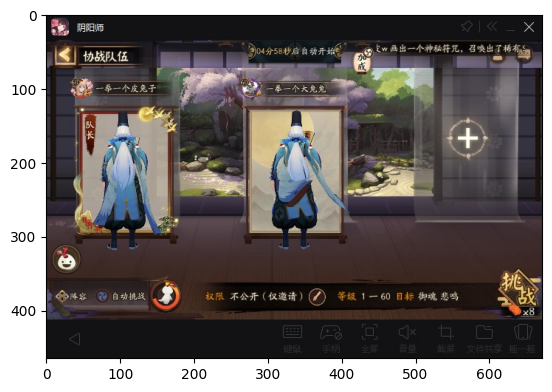

In [11]:
img_dual = cv.imread("../testimg/03-t-23-1.jpg")
# img_dual = cv.imread("testimg/03-t-10-0.jpg")
img_dual = cv.cvtColor(img_dual, cv.COLOR_BGR2RGB)
print(img_dual.shape)
plt.imshow(img_dual)

(128, 128, 3)


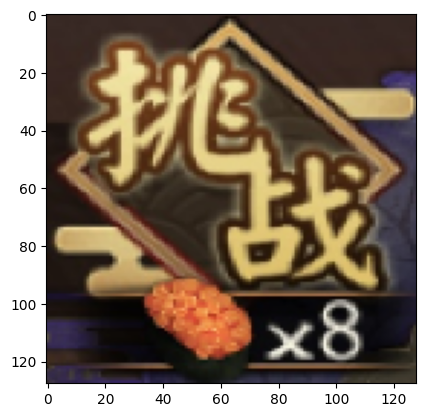

In [12]:
img_t = cv.imread("../pics/03-T.jpg")
img_t = cv.cvtColor(img_t, cv.COLOR_BGR2RGB)
img_t = cv.resize(img_t, [128, 128])
# img_t = cv.resize(img_t, [256, 256])
print(img_t.shape)
plt.imshow(img_t)

In [13]:
detector = challenge_sign_detection()

x = detector.find_sign(img_dual, img_t)

In [14]:
x

[608, 345, 64, 64]